# Reconstruccion testing

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *

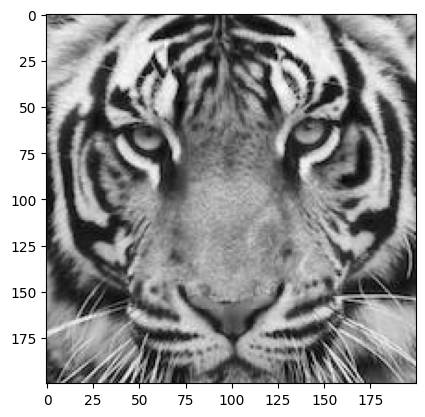

In [2]:
img = cv2.imread('images/g_tiger.jpg',0)

plt.imshow(img,cmap='gray')


## Generacion corriente I

Para generar las corrientes $I(x,y)$ se utiliza el kernel de convolución $D(x,y)$ el cual se define como:

$$ D(x,y) = \frac{1}{2\pi \sigma^{2}_{c}} \cdot e^{-\frac{x^{2}+y^{2}}{2\sigma_{c}^{2}}} - \frac{1}{2\pi \sigma^{2}_{s}} \cdot e^{-\frac{x^{2}+y^{2}}{2\sigma_{s}^{2}}} $$

Se selecciona un tamaño de $3 \times 3$ para el Kernel, con un strid de 1. Note que $D(x,y)$ puede ser interpretado como una diferencia de Gaussianas. 


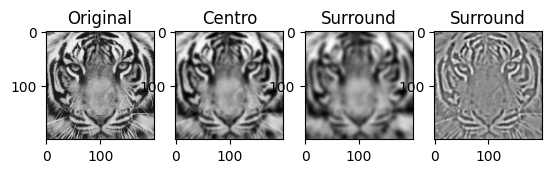

Center shape: (200, 200)
Surround shape: (200, 200)


In [3]:
img = img.astype(np.float32)

sigma_c1 = 1.5
sigma_s1 = 3

kernel_size = 15
# Normalize the pixel values to 0-1

center = cv2.GaussianBlur(img, (kernel_size,kernel_size), sigma_c1)
surround = cv2.GaussianBlur(img, (kernel_size,kernel_size), sigma_s1)
DoG = center - surround

fig, axs = plt.subplots(1,4)

# Original
axs[0].imshow(img,cmap='gray')
axs[0].set_title('Original')
# Center 
axs[1].imshow(center, cmap='gray')
axs[1].set_title('Centro')
#Surround 
axs[2].imshow(surround, cmap='gray')
axs[2].set_title('Surround')
#DoG
axs[3].imshow(DoG, cmap='gray')
axs[3].set_title('Surround')

plt.show()

print('Center shape: {}'.format(center.shape))
print('Surround shape: {}'.format(surround.shape))

## Conversión a Corriente

In [4]:
factor = (1)
r = 1
I_ON = factor*DoG
I_OFF = factor*(-1)*DoG
v0_ON_vals = r*I_ON*mV
v0_OFF_vals = r*I_OFF*mV

print(v0_OFF_vals.shape)

(200, 200)


## Redes ON/OFF

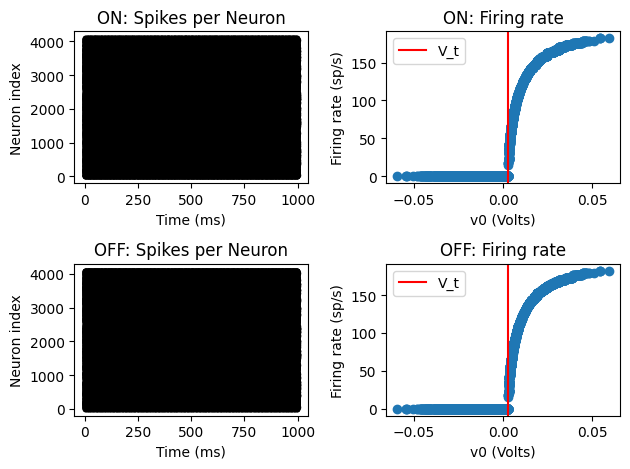

In [5]:
start_scope()
n = 4096
duration = 1*second
tau = 10*ms
vt = 3*mV

coor_spikes = {}

eqs = '''
dv/dt = (v0 - v) / tau : volt (unless refractory)
v0 : volt
x: 1
y: 1
'''
G = NeuronGroup(n, eqs, threshold='v>vt', reset='v= 0*mV', refractory=5*ms, method='exact')
ON = G[0:n//2]
OFF = G[n//2:n]

G.v0 = np.zeros((1,n))
G.x = np.zeros((1,n)) 
G.y = np.zeros((1,n)) 

### REVISAAAAAR
for m in range(n//2):
    k = np.random.randint(0,200,dtype=int)
    j = np.random.randint(0,200,dtype=int)
    G.x[m] = k
    G.y[m] = j
    ON.v0[m] = v0_ON_vals[k][j]
    OFF.v0[m] = v0_OFF_vals[k][j]

    
spikes = SpikeMonitor(G)

run(duration)

#figure(figsize=(12,4))
fig, axs = plt.subplots(2,2)

# ON - spikes per neuron
axs[0][0].plot(spikes.t/ms, spikes.i, '.k')
axs[0][0].set_xlabel('Time (ms)')
axs[0][0].set_ylabel('Neuron index')
axs[0][0].set_title('ON: Spikes per Neuron')
# ON - firing rate
axs[0][1].scatter(G.v0, spikes.count/duration)
axs[0][1].set_xlabel('v0 (Volts)')
axs[0][1].set_ylabel('Firing rate (sp/s)')
axs[0][1].set_title('ON: Firing rate')  
axs[0][1].axvline(x=float(vt), color='r', label='V_t')
axs[0][1].legend()

# OFF - spikes per neuron
axs[1][0].plot(spikes.t/ms, spikes.i, '.k')
axs[1][0].set_xlabel('Time (ms)')
axs[1][0].set_ylabel('Neuron index')
axs[1][0].set_title('OFF: Spikes per Neuron')
# ON - firing rate
axs[1][1].scatter(G.v0, spikes.count/duration)
axs[1][1].set_xlabel('v0 (Volts)')
axs[1][1].set_ylabel('Firing rate (sp/s)')
axs[1][1].set_title('OFF: Firing rate')
axs[1][1].axvline(x=float(vt), color='r', label='V_t')
axs[1][1].legend()  

plt.tight_layout()
plt.show()

In [6]:
def LUT_generator(monitor,neuron_number= 600):
    LUT = {}
    ordered_neurons = {}
    neurons_spikes = {}
    base_dict = monitor.all_values()['t']
    t_spikes = 0
    # Check neurons that generated spikes
    for neuron in base_dict.keys():
        spike_times = base_dict[neuron]
        spike_times.sort()
        n_spikes = len(spike_times)
        if(n_spikes > 0):
            ordered_neurons[neuron] = spike_times[0]
            neurons_spikes[neuron] = n_spikes
            t_spikes += n_spikes

    sorted_neurons = sorted(ordered_neurons.items(), key=lambda x:x[1])
    
    count = 0
    firts_neurons = []
    for neuron in sorted_neurons:
        neuron = neuron[0]
        count += 1
        firts_neurons.append(neuron)
        if(count == neuron_number):
            time_limit = base_dict[neuron][0]
            print(time_limit)
            break
        #LUT[neuron] = np.uint8(neurons_spikes[neuron])#75*neuron s_spikes[neuron]#(127*neurons_spikes[neuron]/t_spikes)

    for nnn in firts_neurons:
        temp = 0
        for spike in base_dict[nnn]:
            if(spike <= time_limit):
                temp +=1
        LUT[nnn] = temp


    return LUT

LUT = LUT_generator(spikes)


1.8 ms


In [25]:
gray_img = 128*np.ones( (200,200,1), dtype=np.uint8)
#print(LUT.keys())
for neuron in LUT:
    temp_sum = int(gray_img[int(G.x[neuron])][ int(G.y[neuron])])
    if (neuron >= 2048):
        if(temp_sum - 20*LUT[neuron] <0):
            gray_img[int(G.x[neuron])][ int(G.y[neuron])] = 0
        else:
            gray_img[int(G.x[neuron])][ int(G.y[neuron])] -= 20*LUT[neuron]
    else:
        if(temp_sum + 20*LUT[neuron] > 255):
            gray_img[int(G.x[neuron])][ int(G.y[neuron])] = 255
        else:
            gray_img[int(G.x[neuron])][ int(G.y[neuron])] += 20*LUT[neuron]

C_POST = cv2.GaussianBlur(gray_img, (kernel_size,kernel_size), sigma_c1)
S_POST = cv2.GaussianBlur(gray_img, (kernel_size,kernel_size), sigma_s1)
DoG_POST = -(C_POST - S_POST)

plt.imshow(gray_img, cmap=plt.get_cmap('gray'),vmin=0,vmax=255)
plt.show()

SyntaxError: invalid syntax (1241483005.py, line 20)